In [112]:
import os
from matplotlib import pyplot as plt, cm
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import scipy as sp
# import seaborn as sns
%matplotlib inline
print(plt.style.available)
# plt.style.use('seaborn-pastel')
plt.style.use('seaborn-notebook')
# plt.style.use('ggplot')
from scikits.audiolab import wavread
from scikits.talkbox.features import mfcc
import pickle
import pdb

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


# check GTZAN data

In [96]:
rootdir = 'genres'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'metal']

In [97]:
sound_names = []
labels = []

for dirpath, dirname, files in os.walk(rootdir):
    for f in files:
        if f.endswith('.wav'):
            sound_names.append(os.path.join(dirpath,f))
            labels.append(dirpath.split('/')[1])
print sound_names[:5], labels[:5]
print len(sound_names)

['genres/blues/blues.00000.wav', 'genres/blues/blues.00001.wav', 'genres/blues/blues.00002.wav', 'genres/blues/blues.00003.wav', 'genres/blues/blues.00004.wav'] ['blues', 'blues', 'blues', 'blues', 'blues']
1000


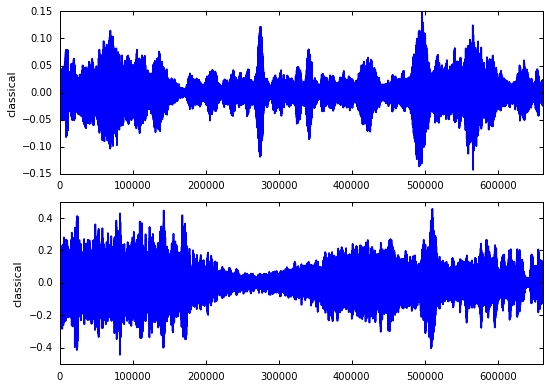

In [98]:
data = []
target = []
number_of_sounds = 1000
for i in range(1, number_of_sounds + 1):
    rand_int = np.random.randint(0,len(sound_names))
    sound_name = sound_names[rand_int]
    label = labels[rand_int]
    try:
        snd = wavread(sound_name)
    except:
        continue
    data.append(snd)
    target.append(label)


data = np.array(data)
target = np.array(target)

def plot_sounds(data_set, labels):
    i = 1
    for snd, label in zip(data_set,labels):
        plt.subplot(len(data_set),1,i)
        plt.plot(snd[0])
        plt.ylabel(label)
        plt.tight_layout()
        plt.xlim([0,len(snd[0])])
        i += 1

plot_sounds(data[:2], target[:2])


# Check FFT

size of fft:  200


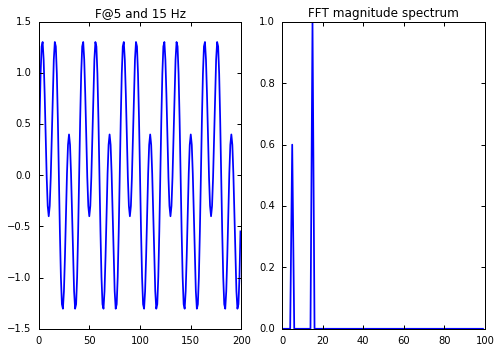

In [99]:
fft_size = 512
hop_size = 256
Fs = 200
f = 5
t = 1
n = np.array(range(Fs * t))
y = 0.6 * np.sin(2 * np.pi * f * n / Fs) + np.sin(2 * np.pi * (f+10) * n / Fs)
fig, axes = plt.subplots(1, 2)
axes[0].plot(n, y)
axes[0].set_title("F@5 and 15 Hz")
spectrum = np.fft.fft(y)
print "size of fft: ", len(spectrum)
axes[1].plot((abs((2. / len(spectrum)) * spectrum[0:len(spectrum) / 2])))
axes[1].set_title("FFT magnitude spectrum")


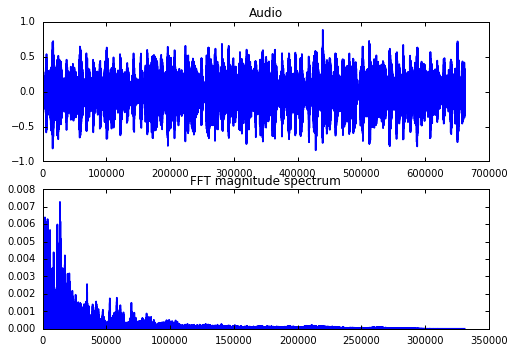

In [102]:
sound, fs, enc = wavread('genres/blues/blues.00000.wav')
fig, axes = plt.subplots(2, 1)
axes[0].plot(sound)
axes[0].set_title("Audio")
spectrum = np.fft.fft(sound)
normalized_half_spectrum = abs((2. / len(spectrum)) * spectrum[0:len(spectrum) / 2])
axes[1].plot(normalized_half_spectrum)
axes[1].set_title("FFT magnitude spectrum")


In [129]:
fft_size = 512
hop_size = 256
print len(data)
print sound

1000
[ 0.00732422  0.01660156  0.00762939 ..., -0.05560303 -0.06106567
 -0.06417847]


In [130]:
def stft(x, fft_size, hop_size):
    n_hops = len(x) // hop_size
    s = []
    # each row is value, Fs, encoding
    window = np.hanning(fft_size)
    for i in range(n_hops):
        frame = x[(i * hop_size):(i * hop_size + fft_size)]
        # frame is always of size fft_size except at boundaries where we do zero padding
        frame = np.pad(frame, (0, fft_size-len(frame)), 'constant')
#         pdb.set_trace()
        frame *= window
        spectrum = np.fft.fft(frame)
        magnitude = abs((2. / len(spectrum)) * spectrum[0:len(spectrum) / 2])
        s.append(magnitude)
    return s

t_spectrum = stft(sound, fft_size, hop_size)

661794

(2585, 256)
256


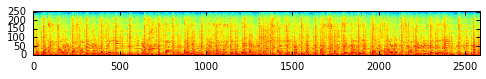

In [131]:
print np.shape(t_spectrum)
print len(np.mean(t_spectrum, axis=0))
plt.imshow(np.log(np.transpose(np.array(t_spectrum) + 1e-10)))
plt.gca().invert_yaxis()

In [142]:
def compute_features(data_set, hope_size, fft_size):
    X = []
    idx = 0
    for track in data_set:
        # 1 vector of dimension 256 for the whole track
        spectrum = stft(track, fft_size, hop_size)
        X.append(np.mean(spectrum, axis = 0))
    return np.array(X)

X = compute_features(data[:200,0], hop_size, fft_size)

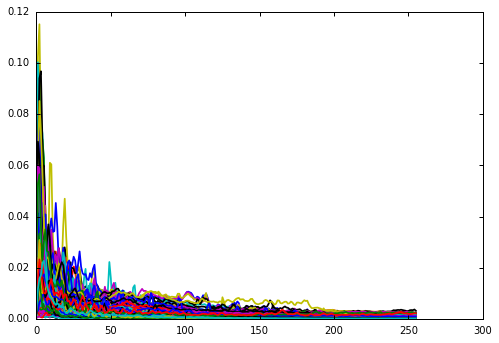

In [144]:
plt.plot(X.T);

In [145]:
# pickled = {}
# pickled['X'] = X
# pickled['y'] = target
# pickle.dump(pickled, open( "deep_genre_classification_X_y.pkl", "wb" ) )

In [147]:
pickled = pickle.load( open( "deep_genre_classification_X_y.pkl", "rb" ) )
X = pickled['X']
target = pickled['y']

In [148]:
y = target
print y[0:4]

['classical' 'classical' 'jazz' 'jazz']


# DNN

In [91]:
seed = 7
np.random.seed(seed)

In [149]:
encoded = pd.get_dummies(target)
encoded.columns

Index([u'blues', u'classical', u'country', u'disco', u'hiphop', u'jazz',
       u'metal', u'pop', u'reggae', u'rock'],
      dtype='object')

In [150]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
print len(X)
y = encoded.values[:len(X)]
print len(y)

200
200


In [151]:
print "mean: {} std: {}".format(X_scaled.mean(), X_scaled.std())
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33)
print "unique classes: ", np.unique(target)
print "number of classes:", len(np.unique(target))

mean: 4.4408920985e-18 std: 1.0
unique classes:  ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
number of classes: 10


In [152]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop

In [188]:
model = Sequential()
model.add(Dense(32, input_dim=256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))
#model.summary()

In [189]:
model.compile(optimizer=RMSprop(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [196]:
batch_size = 10
nb_classes = 10
nb_epoch = 500

history = model.fit(X_train, y_train, 
          nb_epoch=nb_epoch, 
          batch_size=batch_size, 
#           validation_data=(X_test, y_test),
          validation_split=0.2,
          verbose=1)

Train on 107 samples, validate on 27 samples
Epoch 1/500
107/107 [==============================] - 0s - loss: 0.8042 - acc: 0.7009 - val_loss: 1.5585 - val_acc: 0.7407
Epoch 2/500
107/107 [==============================] - 0s - loss: 0.6673 - acc: 0.8411 - val_loss: 1.3188 - val_acc: 0.7407
Epoch 3/500
107/107 [==============================] - 0s - loss: 1.0110 - acc: 0.7196 - val_loss: 1.4101 - val_acc: 0.7778
Epoch 4/500
107/107 [==============================] - 0s - loss: 0.8910 - acc: 0.6822 - val_loss: 1.3774 - val_acc: 0.7778
Epoch 5/500
107/107 [==============================] - 0s - loss: 0.7345 - acc: 0.8037 - val_loss: 1.4452 - val_acc: 0.7778

In [197]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

32/66 [=============>................] - ETA: 0s('Test score:', 4.3515453338623047)
('Test accuracy:', 0.53030303030303028)


In [169]:
#print history.history

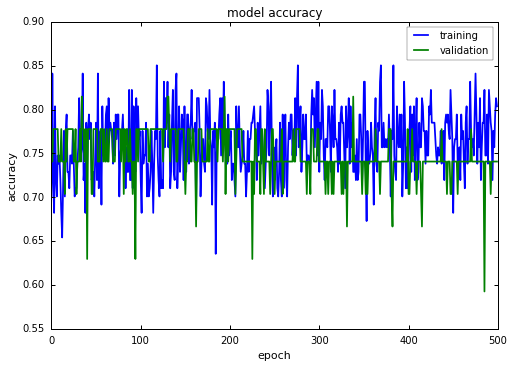

In [198]:
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()